In [1]:
import numpy as np
import pandas as pd
import xgboost as xgboost
import matplotlib.pyplot as plt
import seaborn as sns

from xgboost import XGBClassifier
from bayes_opt import BayesianOptimization
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import confusion_matrix
from sklearn.calibration import calibration_curve


In [2]:
## functions
def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample_bytree,
                        gamma,
                        min_child_weight,
                        reg_lambda,
                        alpha,
                        scale_pos_weight):

    max_depth = int(max_depth)
    n_estimators = int(n_estimators)

    clf = XGBClassifier(
        max_depth=max_depth,
        learning_rate=learning_rate,
        n_estimators=n_estimators,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        gamma=gamma,
        min_child_weight=min_child_weight,
        reg_lambda=reg_lambda,
        alpha=alpha,
        scale_pos_weight=scale_pos_weight,
        tree_method='gpu_hist')
    #return np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc'))
    return np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='f1'))

def train_xgboost(dt, best_params, n_splits=10):
    # Extract the feature and target columns from the DataFrame
    X = dt.drop(['label', 'id'], axis=1)
    y = dt['label']

    # Create the XGBoost model
    model = xgboost.XGBClassifier(
        learning_rate=best_params['params']['learning_rate'], 
        max_depth=int(best_params['params']['max_depth']),
        #max_depth=1,
        min_child_weight=int(best_params['params']['min_child_weight']),
        subsample=best_params['params']['subsample'],
        gamma=best_params['params']['gamma'],
        colsample_bytree=best_params['params']['colsample_bytree'],
        objective='binary:logistic',
        n_estimators=int(best_params['params']['n_estimators']),
        reg_lambda=best_params['params']['reg_lambda'],
        alpha=best_params['params']['alpha'],
        scale_pos_weight=best_params['params']['scale_pos_weight'],
        #scale_pos_weight=0.25,
        tree_method='gpu_hist'
    )

    # Create a KFold object for cross-validation
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)
    
    # Train the model using k-fold cross-validation
    scores = []
    y_true = []
    y_pred_proba = []
    for train_index, test_index in kfold.split(X):
        X_train, X_test = X.iloc[train_index], X.iloc[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        model.fit(X_train, y_train)
        scores.append(model.score(X_test, y_test))
        y_true.extend(y_test)
        y_pred_proba.extend(model.predict_proba(X_test)[:, 1])
    
    # Combine the ground truth and predictions into a single DataFrame
    df_results = pd.DataFrame({'y_true': y_true, 'y_pred_proba': y_pred_proba})
    
    return model, scores, df_results

def create_final_model(dt,
                       duration_num,
                       thresh_num,
                       ratio_num,
                       best_params):
    
    X = dt.drop(['label', 'id'], axis=1)
    y = dt['label']

    model_final = xgboost.XGBClassifier(
            learning_rate=best_params['params']['learning_rate'], 
            max_depth=int(best_params['params']['max_depth']),
            #max_depth=1,
            min_child_weight=int(best_params['params']['min_child_weight']),
            subsample=best_params['params']['subsample'],
            gamma=best_params['params']['gamma'],
            colsample_bytree=best_params['params']['colsample_bytree'],
            objective='binary:logistic',
            n_estimators=int(best_params['params']['n_estimators']),
            reg_lambda=best_params['params']['reg_lambda'],
            alpha=best_params['params']['alpha'],
            scale_pos_weight=best_params['params']['scale_pos_weight'],
            #scale_pos_weight=0.25,
            tree_method='gpu_hist'
        )
    model_final.fit(X, y)

    final_model_path = '/home/chris/Documents/code/cbg_code/unipoc_xgb_models/duration_' + str(duration_num) + '_threshold_' + str(thresh_num) + '_ratio_' + str(ratio_num) + '_final_model.model'
    model_final.save_model(final_model_path)
    
def plot_roc_curve(y_true, y_pred_proba):
    # Calculate the false positive rate and true positive rate
    fpr, tpr, _ = roc_curve(y_true, y_pred_proba)
    
    # Plot the ROC curve
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('False positive rate')
    plt.ylabel('True positive rate')

def calculate_optimal_threshold(y_true, y_pred_proba):
    # Calculate the false positive rate and true positive rate
    fpr, tpr, thresholds = roc_curve(y_true, y_pred_proba)
    
    # Calculate the g-mean for each threshold
    gmeans = np.sqrt(tpr * (1-fpr))
    
    # Locate the index of the largest g-mean
    ix = np.argmax(gmeans)
    
    return thresholds[ix]

def plot_precision_recall_curve(y_true, y_pred_proba):
    # Calculate the precision and recall
    precision, recall, _ = precision_recall_curve(y_true, y_pred_proba)
    
    # Plot the precision-recall curve
    plt.plot(recall, precision)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    
def plot_confusion_matrix(y_true, y_pred):
    # Calculate the confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    print(cm)
    
    # Plot the confusion matrix with large font size
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.xlabel('Predicted label')
    plt.ylabel('True label')
    
def plot_calibration_curve(df_results):
    # Extract the true and predicted probability columns from the DataFrame
    y_true = df_results['y_true']
    y_pred_proba = df_results['y_pred_proba']

    # Calculate the fraction of positive examples
    fraction_of_positives, mean_predicted_value = calibration_curve(
        y_true, y_pred_proba, n_bins=10)

    # Plot the calibration curve
    plt.plot(mean_predicted_value, fraction_of_positives, 's-')
    plt.plot([0, 1], [0, 1], '--', color='gray')
    plt.xlabel('Predicted probability')
    plt.ylabel('Fraction of positives')
    
def plot_feature_importance(model, importance_type = 'weight'):
    feature_important = model.get_booster().get_score(importance_type=importance_type)
    keys = list(feature_important.keys())
    values = list(feature_important.values())
    
    data = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)
    data.nlargest(40, columns="score").plot(kind='barh', figsize = (20,10)) ## plot top 40 features

# concatenate auroc and threshold and save out as .csv file
def save_auc_threshold(auroc, optimal_threshold, duration_num, thresh_num, ratio_num):
    auroc_threshold = np.array([auroc, optimal_threshold])
    auroc_threshold = auroc_threshold.reshape(1,2)
    auroc_threshold = pd.DataFrame(auroc_threshold)
    auroc_threshold.columns = ['auroc', 'threshold']
    auroc_threshold_path = '/home/chris/Documents/data/CBGdata/unipoc_model_auroc_threshold/duration_' + str(duration_num) + '_threshold_' + str(thresh_num) + '_ratio_' + str(ratio_num) + '_auroc_threshold.csv'
    auroc_threshold.to_csv(auroc_threshold_path, index=False)

In [3]:
def build_model(duration_num,
                thresh_num,
                ratio_num,
                bayes_init_points,
                bayes_opt_iters,
                bayes_scoring):
    
    print('duration: ' + str(duration_num) + ', threshold: ' + str(thresh_num) + ', ratio: ' + str(ratio_num))
    
    # load data
    # define path with variables
    path = '~/Documents/data/CBGdata/unipoc_xgboost_ready/duration_' + str(duration_num) + '_threshold_' + str(thresh_num) + '_ratio_' + str(ratio_num) + '.csv'

    dt = pd.read_csv(path, index_col = False)
    print(dt.shape)
    
    # print the sum of the labels
    print(dt['label'].sum())
    
    ## bayesian optimization
    X_train = dt.drop(['label', 'id'], axis=1)
    y_train = dt['label']

    pbounds = {
        'learning_rate': (0.001, 1.0),
        'n_estimators': (1, 1000),
        'max_depth': (1,40),
        'subsample': (0, 1.0),  # Change for big datasets
        'colsample_bytree': (0, 1.0),  # Change for datasets with lots of features
        'gamma': (0, 5),
        'min_child_weight': (0, 5),
        'reg_lambda': (0, 5),
        'alpha': (0, 5),
        'scale_pos_weight': (0, 20)}
    
    def xgboost_hyper_param(learning_rate,
                        n_estimators,
                        max_depth,
                        subsample,
                        colsample_bytree,
                        gamma,
                        min_child_weight,
                        reg_lambda,
                        alpha,
                        scale_pos_weight):

        max_depth = int(max_depth)
        n_estimators = int(n_estimators)

        clf = XGBClassifier(
            max_depth=max_depth,
            learning_rate=learning_rate,
            n_estimators=n_estimators,
            subsample=subsample,
            colsample_bytree=colsample_bytree,
            gamma=gamma,
            min_child_weight=min_child_weight,
            reg_lambda=reg_lambda,
            alpha=alpha,
            scale_pos_weight=scale_pos_weight,
            tree_method='gpu_hist')
        #return np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring='roc_auc'))
        return np.mean(cross_val_score(clf, X_train, y_train, cv=10, scoring=bayes_scoring))

    optimizer = BayesianOptimization(
        f=xgboost_hyper_param,
        pbounds=pbounds,
        random_state=2,
    )

    # Perform the Bayesian optimization
    optimizer.maximize(init_points = bayes_init_points, n_iter=bayes_opt_iters)

    # Return the best hyperparameters
    best_params = optimizer.max
    
    ## print and save out best params
    print(best_params)
    params_path = '~/Documents/data/CBGdata/unipoc_model_best_params/duration_' + str(duration_num) + '_threshold_' + str(thresh_num) + '_ratio_' + str(ratio_num) + '_best_params_' + str(bayes_opt_iters) + '_iters.csv'

    # save best_params to csv
    best_params_df = pd.DataFrame(best_params)
    best_params_df.to_csv(params_path)
    
    ## cross validate model to assess performance
    model, scores, df_results = train_xgboost(dt, best_params, 10)
    print(df_results.head()) # print out results head()
    
    ## create and save final model
    create_final_model(dt, duration_num, thresh_num, ratio_num, best_params)
    
    ## calculate auroc
    auroc = roc_auc_score(df_results['y_true'], df_results['y_pred_proba'])
    print(auroc)
    
    # plot auc and calculate the optimal threshold
    plot_roc_curve(df_results['y_true'], df_results['y_pred_proba'])
    threshold = calculate_optimal_threshold(df_results['y_true'], df_results['y_pred_proba'])
    print(threshold)

    optimal_threshold = threshold
    
    print('pre auroc')
    # concatenate auroc and threshold and save out as .csv file
    save_auc_threshold(auroc, optimal_threshold, duration_num, thresh_num, ratio_num)
    
    # plot precision-recall curve
    #plot_precision_recall_curve(df_results['y_true'], df_results['y_pred_proba'])
    
    # apply threshold to predictions
    df_results['y_pred'] = df_results['y_pred_proba'].apply(lambda x: 1 if x > optimal_threshold else 0)
    #plot_confusion_matrix(df_results['y_true'], df_results['y_pred'])
    
    # plot calibration curve
    #plot_calibration_curve(df_results)
    
    # plot feature importance
    #plot_feature_importance(model, 'weight')
    #plot_feature_importance(model, 'gain')
    
    print('end')

duration: 3, threshold: 3, ratio: all
(30549, 33)
1219
|   iter    |  target   |   alpha   | colsam... |   gamma   | learni... | max_depth | min_ch... | n_esti... | reg_la... | scale_... | subsample |
-------------------------------------------------------------------------------------------------------------------------------------------------
| 1         | 0.251     | 2.18      | 0.02593   | 2.748     | 0.4359    | 17.39     | 1.652     | 205.4     | 3.096     | 5.993     | 0.2668    |
| 2         | 0.1752    | 3.106     | 0.5291    | 0.6729    | 0.5141    | 8.193     | 3.927     | 854.1     | 2.471     | 16.93     | 0.07965   |
| 3         | 0.3205    | 2.526     | 0.06529   | 2.141     | 0.09743   | 5.959     | 2.984     | 226.8     | 0.5347    | 4.406     | 0.3498    |
| 4         | 0.2698    | 2.339     | 0.2017    | 3.202     | 0.4836    | 20.7      | 1.934     | 793.8     | 2.9       | 3.246     | 0.7008    |
| 5         | 0.3033    | 4.823     | 0.5       | 4.448     | 0.3423 

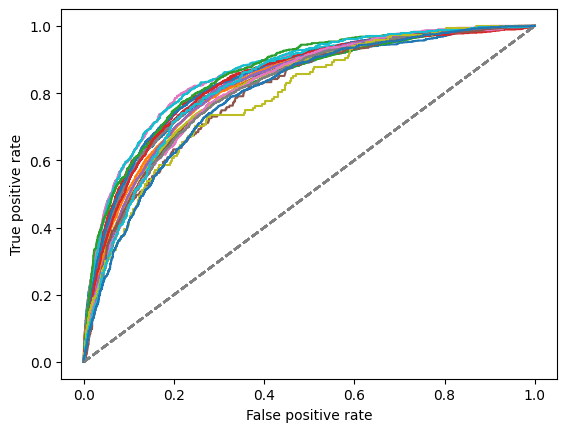

In [4]:
duration_vec = [3, 4, 5, 6, 7, 21, 30]
thresh_vec   = [3,4,5]
ratio_vec    = ['all']

bayes_init_points = 5
bayes_opt_iters   = 20
bayes_scoring     = 'f1'

# loop through all combinations of duration, threshold and ratio
for duration_num in duration_vec:
    for thresh_num in thresh_vec:
        for ratio_num in ratio_vec:
            build_model(duration_num=duration_num,
                        thresh_num=thresh_num,
                        ratio_num=ratio_num,
                        bayes_init_points = bayes_init_points,
                        bayes_opt_iters=bayes_opt_iters,
                        bayes_scoring=bayes_scoring)
